# Implementing a Multilayer Perceptron (MNIST)

## 1) Installing Libraries

In [1]:
# !conda install numpy pandas matplotlib --yes

In [2]:
# !pip install torch torchvision torchaudio

In [3]:
# !conda install watermark

In [4]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.2
matplotlib: 3.6.2
torch     : 1.13.0



## 2) Loading the dataset

- MNIST website: http://yann.lecun.com/exdb/mnist/

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [6]:
len(train_dataset)

60000

In [7]:
len(test_dataset)

10000

### Create a validation set

In [8]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [9]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

### Check label distribution

In [10]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

    
val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


## 3) Zero-rule baseline (majority class classifier)

In [11]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


## 4) A quick visual check

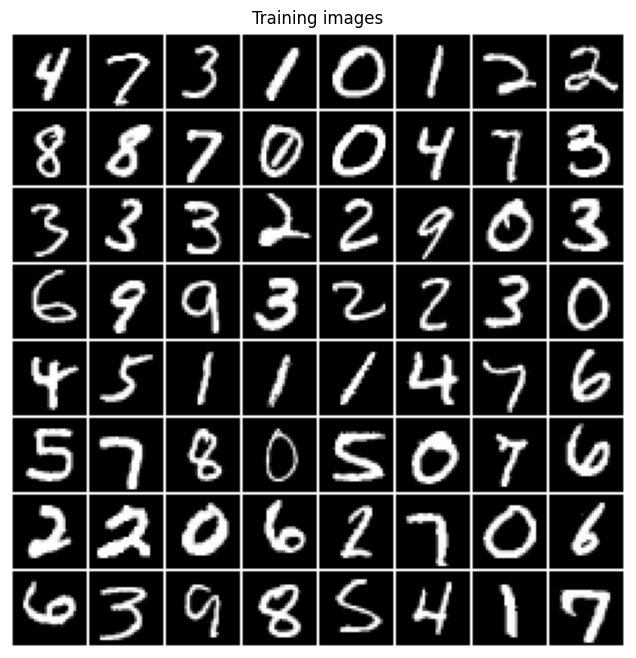

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

## 5) Implementing the model

In [13]:
images.shape # batchsize, channel, height, width

torch.Size([64, 1, 28, 28])

![](./img/mnist-reshape.png)

In [14]:
import torch

torch.flatten(images, start_dim=1).shape # batchsize, features

torch.Size([64, 784])

In [15]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

## 6) The training loop

- Exactly the same accuracy function as before

In [16]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

- Exactly the same training loop as before

In [17]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/860 | Train Loss: 2.34
Epoch: 001/010 | Batch 250/860 | Train Loss: 0.68
Epoch: 001/010 | Batch 500/860 | Train Loss: 0.29
Epoch: 001/010 | Batch 750/860 | Train Loss: 0.30
Train Acc 88.70% | Val Acc 88.22%
Epoch: 002/010 | Batch 000/860 | Train Loss: 0.36
Epoch: 002/010 | Batch 250/860 | Train Loss: 0.41
Epoch: 002/010 | Batch 500/860 | Train Loss: 0.44
Epoch: 002/010 | Batch 750/860 | Train Loss: 0.25
Train Acc 91.84% | Val Acc 91.12%
Epoch: 003/010 | Batch 000/860 | Train Loss: 0.28
Epoch: 003/010 | Batch 250/860 | Train Loss: 0.20
Epoch: 003/010 | Batch 500/860 | Train Loss: 0.18
Epoch: 003/010 | Batch 750/860 | Train Loss: 0.26
Train Acc 93.71% | Val Acc 92.86%
Epoch: 004/010 | Batch 000/860 | Train Loss: 0.18
Epoch: 004/010 | Batch 250/860 | Train Loss: 0.14
Epoch: 004/010 | Batch 500/860 | Train Loss: 0.25
Epoch: 004/010 | Batch 750/860 | Train Loss: 0.23
Train Acc 94.80% | Val Acc 93.54%
Epoch: 005/010 | Batch 000/860 | Train Loss: 0.13
Epoch: 005/010